This is the same Home Work 2 submission, In my previous submission I didnt use matplotlib inline function for 4 points and 8 points image mapping. This is the updated ipynb file with the plots

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg') # Using TkAgg backend for interactive plotting

In [2]:
# Selecting the points using matlpotlib's ginput function
def select_points(image, num_points, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    points = plt.ginput(num_points, timeout=0)
    plt.close()
    return np.array(points, dtype='float32')

In [3]:
# Homography Calculation using Least Square Method
def compute_homography(src_pts, dst_pts):
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0], src_pts[i][1]
        x_prime, y_prime = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
        A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    H = H / H[2, 2]  # Normalize
    return H

Homography Calculation is done using Least Squares Method

In [4]:
# Using OpenCV's Warp function
def warp_image(image1, image2, pts_image1, pts_image2):
    H = compute_homography(pts_image2, pts_image1)
    warped_image = cv2.warpPerspective(image2, H, (image1.shape[1], image1.shape[0]))

    # Creating a mask for the warped image area
    mask = np.zeros((image1.shape[0], image1.shape[1]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, pts_image1.astype(int), 255)
    mask = np.stack([mask]*3, axis=-1)

    # Combining images using the mask
    masked_image1 = cv2.bitwise_and(image1, cv2.bitwise_not(mask))
    masked_warped_image = cv2.bitwise_and(warped_image, mask)
    final_image = cv2.add(masked_image1, masked_warped_image)
    
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.title('Mapped Image on Wall')
    %matplotlib inline
    plt.show()
    print("Calculated Hompography: \n",H)

In [5]:
# Input images are read using cv2.imread function
image1 = cv2.imread('image1.jpg')  # Image with the wall
image2 = cv2.imread('image2.jpg')  # Image to map onto the wall
image3 = cv2.imread('image3.jpg')  # Another image to map

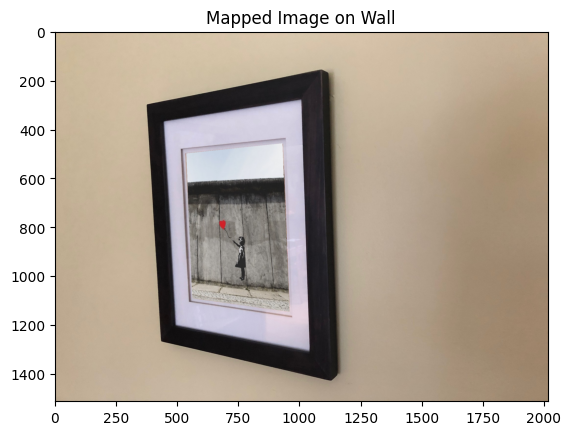

Calculated Hompography: 
 [[ 5.84827137e-01  6.40362621e-02  5.35039302e+02]
 [-2.39702311e-01  1.34554177e+00  4.97211414e+02]
 [-3.21453837e-04  1.14171761e-05  1.00000000e+00]]


In [6]:
# Mapping images using 4 point selection
matplotlib.use('TkAgg')
pts_image1 = select_points(image1, 4, 'Click on the four corners of the wall in Image 1')
pts_image2 = select_points(image2, 4, 'Click on the four corners in Image 2')
warp_image(image1, image2, pts_image1, pts_image2)

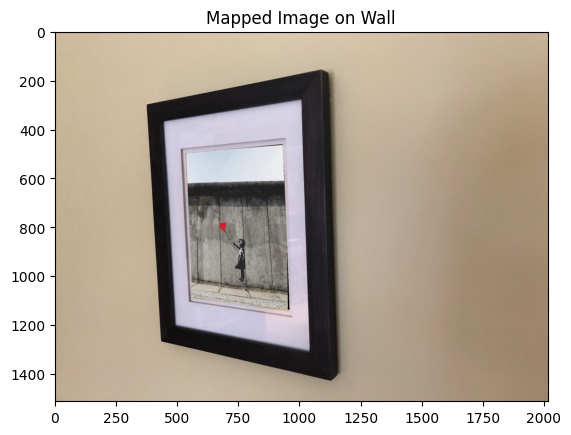

Calculated Hompography: 
 [[ 6.03461055e-01  1.18888927e-01  5.35001177e+02]
 [-2.24195923e-01  1.44099976e+00  4.97834563e+02]
 [-3.23337805e-04  1.07264765e-04  1.00000000e+00]]


In [7]:
# Mapping images using 8 point selection
matplotlib.use('TkAgg')
pts_image1_8 = select_points(image1, 8, 'Click on eight corners in Image 1')
pts_image2_8 = select_points(image2, 8, 'Click on the eight corners in New Image')
warp_image(image1, image2, pts_image1_8, pts_image2_8)

Mapping Precision: When calculating the homography matrix using 8 points, it generally gives a better and more accurate transformation of the images. This is especially true if these 8 points are well-distributed and highlight key features in the images. The least squares method helps by minimizing the error across all 8 points, leading to a more precise transformation.

Effect on Warping: With the improved homography from using 8 points, the warping (how one image is adjusted to fit another) will be smoother and have fewer distortions. In contrast, if only 4 points are used, the transformation might overfit the corners and result in more noticeable distortions.

Numerical Differences: When compared the two homography matrices (one calculated with 4 points and the other with 8 points), slight numerical differences can be observed. These differences arise because the additional points affect how scaling, translation, and rotation are handled in the transformation.

Overall, using more points to compute the homography matrix generally results in a more accurate and realistic transformation of the images.

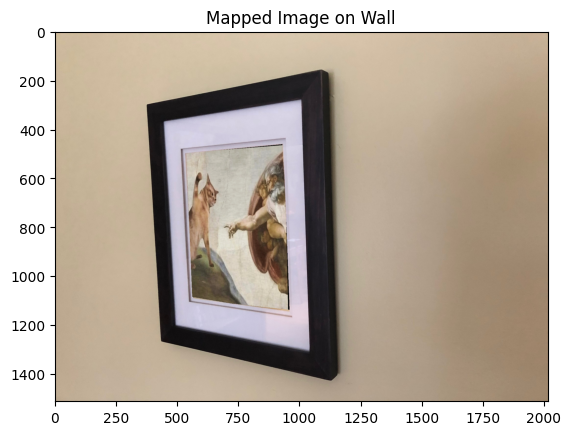

Calculated Hompography: 
 [[ 2.24886807e-01  3.61955903e-02  5.36477367e+02]
 [-8.62044910e-02  5.74275667e-01  4.97803110e+02]
 [-1.25935246e-04  2.48941842e-05  1.00000000e+00]]


In [8]:
# Mapping new image to image 1
matplotlib.use('TkAgg')
pts_image3 = select_points(image3, 8, 'Click on the eight corners in Image 3')
warp_image(image1, image3, pts_image1_8, pts_image3)

Stitching images 1 and 2...
Stitching images 5 and 4...
Stitching the result of (1&2) with image 3...
Stitching the result of ((1&2)&3) with (4&5)...


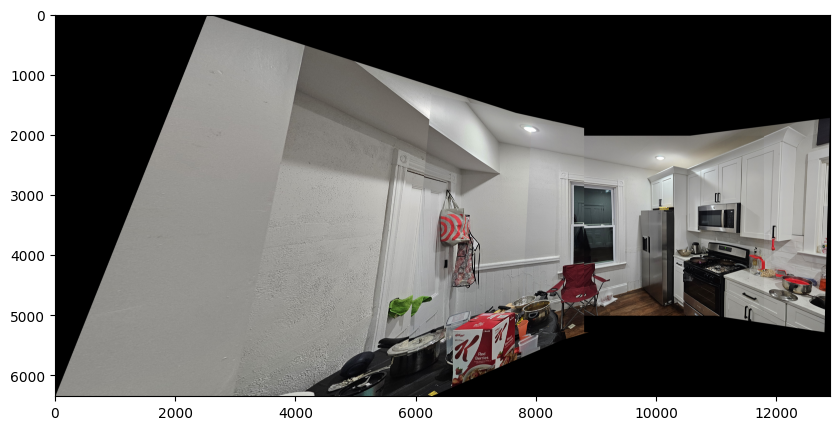

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

def calc_H(points_source, points_target):
    points_source_norm, T_source = normalize_points(points_source)
    points_target_norm, T_target = normalize_points(points_target)
    A = construct_A(points_source_norm, points_target_norm)
    _, _, vh = np.linalg.svd(A)
    homography = vh[-1].reshape((3, 3))
    homography = np.dot(np.linalg.inv(T_target), np.dot(homography, T_source))

    return homography / homography[2, 2]

def normalize_points(points):
    centroid = np.mean(points, axis=0)
    scale = np.sqrt(2) / np.mean(np.linalg.norm(points - centroid, axis=1))
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0, 0, 1]])
    
    points_homogeneous = np.column_stack((points, np.ones(len(points))))
    points_normalized = np.dot(T, points_homogeneous.T).T

    return points_normalized[:, :2], T

def construct_A(points_source, points_target):
    num_points = points_source.shape[0]

    matrices = []
    for i in range(num_points):
        partial_A = construct_A_partial(points_source[i], points_target[i])
        matrices.append(partial_A)
    return np.vstack(matrices)

def construct_A_partial(point_source, point_target):
    x, y, z = point_source[0], point_source[1], 1
    x_t, y_t, z_t = point_target[0], point_target[1], 1

    A_partial = np.array([
        [0, 0, 0, -z_t*x, -z_t*y, -z_t*z, y_t*x, y_t*y, y_t*z],
        [z_t*x, z_t*y, z_t*z, 0, 0, 0, -x_t*x, -x_t*y, -x_t*z]
    ])
    return A_partial

# Set backend for matplotlib
matplotlib.use('TkAgg')

# Function to pick corresponding points from two images manually
def pick_points(img1, img2):
    plt.figure(figsize=(10, 5)) 
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title('Select points from Image 1')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title('Select corresponding points from Image 2')
    plt.show()

    # Pick 4 corresponding points in both images manually
    points = plt.ginput(8, timeout=-1)  # 8 points in total, 4 for img1 and 4 for img2
    plt.close()

    points = np.array(points)
    points_src = points[:4]  # First 4 points for image 1
    points_dst = points[4:]  # Last 4 points for image 2

    return points_src, points_dst

# Function to calculate homography matrix using point correspondences
def compute_homography(points_src, points_dst):
    H= calc_H(points_src, points_dst)
    return H

# Warp and stitch two images using the calculated homography matrix
def warp_and_stitch(image1, image2, H):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    # Corners of the second image
    corners = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype='float32').reshape(-1, 1, 2)

    # Warp the corners to determine the bounds of the resulting stitched image
    warped_corners = cv2.perspectiveTransform(corners, H)
    all_corners = np.concatenate((warped_corners, np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype='float32').reshape(-1, 1, 2)))

    # Calculate the size of the output image
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    translation_dist = [-xmin, -ymin]

    # Warp the first image into the new space
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    result = cv2.warpPerspective(image1, H_translation @ H, (xmax - xmin, ymax - ymin))

    # Overlay the second image
    result[translation_dist[1]:translation_dist[1] + h2, translation_dist[0]:translation_dist[0] + w2] = image2

    return result


# Stitch images function with manual point selection
def stitch_images_manual(images):
     # Step 1: Stitch images 1 and 2
    print("Stitching images 1 and 2...")
    points_src, points_dst = pick_points(images[0], images[1])
    H_1_2 = compute_homography(points_src, points_dst)
    stitched_1_2 = warp_and_stitch(images[0], images[1], H_1_2)
    #stitched_1_2 = crop_image(stitched_1_2)

    # Step 2: Stitch images 5 and 4
    print("Stitching images 5 and 4...")
    points_src, points_dst = pick_points(images[4], images[3])
    H_5_4 = compute_homography(points_src, points_dst)
    stitched_5_4 = warp_and_stitch(images[4], images[3], H_5_4)
    #stitched_5_4 = crop_image(stitched_5_4)

    # Step 3: Stitch the result of (1&2) with image 3
    print("Stitching the result of (1&2) with image 3...")
    points_src, points_dst = pick_points(stitched_1_2, images[2])
    H_1_2_3 = compute_homography(points_src, points_dst)
    stitched_1_2_3 = warp_and_stitch(stitched_1_2, images[2], H_1_2_3)
    #stitched_1_2_3 = crop_image(stitched_1_2_3)

    # Step 4: Stitch the result of ((1&2)&3) with (4&5)
    print("Stitching the result of ((1&2)&3) with (4&5)...")
    points_src, points_dst = pick_points(stitched_1_2_3, stitched_5_4)
    H_final = compute_homography(points_src, points_dst)
    final_stitched_image = warp_and_stitch(stitched_1_2_3, stitched_5_4, H_final)
    #final_stitched_image = crop_image(final_stitched_image)

    return final_stitched_image

# Crop image to remove black padding
def crop_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    cropped_img = img[y:y+h, x:x+w]
    return cropped_img

# Example usage
folder = "New folder/"
fileType = ".jpg"
ImageFiles = ['1', '2', '3', '4', '5']
images = [cv2.imread(folder + file + fileType) for file in ImageFiles]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None for img in images]



# Resize images for faster stitching
#images = [cv2.resize(img, (0, 0), fx=0.1, fy=0.1) for img in images]

# Stitch images with manual point selection
stitched_image = stitch_images_manual(images)

# Crop the final stitched result
cropped_stitched_image = crop_image(stitched_image)
%matplotlib inline
# Display final stitched result
plt.figure(figsize=(10, 10))
#plt.imshow(stitched_image)
plt.imshow(cropped_stitched_image)
# plt.title("Final Stitched Image")
# plt.axis('off')
# plt.show()


Comparison of Image Blending Methods
The OpenCV tutorial focuses on a simple linear blending technique using the addWeighted() function, which applies a weighted sum of two images
. This method is straightforward and easy to implement, but it may produce visible seams or ghosting effects.
In contrast, the CMU lecture presents more advanced techniques, particularly the Laplacian Pyramid blending
. This method decomposes images into multiple frequency bands, allowing for smoother blending across different scales. It's more complex but can produce higher quality results, especially for images with varying frequency content.
The Laplacian Pyramid approach is better at preserving high-frequency details while smoothly blending low-frequency components, resulting in more natural-looking composites compared to simple linear blending